# <div style='font-size:105%; font-family:Arial'> Car Insurance Claim Amounts Prediction <span style="float:right;"> V. Ganci </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> <hr style="border-top: 2px solid black; margin-top: 2px; margin-bottom: 0px;"> </div>

Table of contents:
<ul>
    <li style='margin-bottom: 5px'><a href="#intro"> 0. Intro, Libraries & Functions </a></li>
    <li style='margin-bottom: 5px'><a href="#data"> 1. Data Overview </a></li>
    <li style='margin-bottom: 5px'><a href="#eda"> 2. Data Cleaning, Feature Engineering & EDA </a></li>
    <li style='margin-bottom: 5px'><a href="#model"> 3. Modeling </a></li>
    <li style='margin-bottom: 5px'><a href="#end"> 4. Results & Next Steps </a></li>
</ul>

<a id='intro'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Intro, Libraries & Functions   <span style="float:right;"> 0. </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

The objective of the case study is to model the expected loss amount per policyholder and per year based on customers' risk characteristics.

After data cleaning, feature engineering and the EDA phase, my strategy for predicting the target variables consists of an initial logistic XGBoost classification model and a subsequent XGBoost regression model. The classification model predicts whether the damage level will be zero (0) or strictly higher (1). The regression model aims to improve the strictly positive predictions.

I conclude the notebook with a summary of the results and the possible next steps.

In [1]:
# Importing libraries

import os

import arff
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(6,2)}, style='whitegrid')

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
import xgboost as xgb

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score, r2_score

# Filtering out FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Create Results folder if not existing

if not os.path.exists(os.path.join('.', 'Results')):
    os.makedirs(os.path.join('.', 'Results'))

In [3]:
def Dataset_Distributions(df, save=False):
    
    '''Plots histograms and box-&-wiskers plots for each variable in the dataset df.
       Save = True to save plots'''
    
    for feature_i in range(df.shape[1]):
        
        fig, ax = plt.subplots(2, 1, figsize = (8,6), gridspec_kw={'height_ratios': [2, 1]})
        plt.subplots_adjust(hspace=0.3)
        
        bins = int(np.sqrt(len(df)))
        
        fig.suptitle(df.columns[feature_i]+" Count Distribution", y=0.95, fontsize=14)
        
        ax[0].hist(df.iloc[:, feature_i], bins=bins, color='C0', edgecolor='k', zorder=2)
        ax[0].set(xlabel='', ylabel='Counts')
        ax[0].grid(ls='--', zorder=0)
        
        if type(df.loc[0, df.columns[feature_i]]) != str:
            sns.boxplot(df.iloc[:, feature_i], orient='h', ax=ax[1])
            ax[1].set(xlabel=df.columns[feature_i], ylabel='')
            ax[1].set_yticks([])
            ax[1].set_yticklabels([])
        else:
            ax[1].axis('off')
        
        plt.show()
        
        if save == True:
            fig.savefig('Results/' +df.columns[feature_i] +"_Count_Distribution.jpg", dpi=250, bbox_inches='tight')
        
        
def Outliers_Limits(feature):
    
    '''returns lower- and upper-limit to define outliers in a feature (dataframe column)'''
    
    percentile25 = feature.quantile(0.25)
    percentile75 = feature.quantile(0.75)   
    iqr = percentile75 - percentile25
    
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    
    return([lower_limit, upper_limit])


def Target_Predictor(target_1, target_2, predictor, save=False):
    
    '''Plots column target_1 grouped by column predictor vs. column predictor, 
       and column target_2 grouped by column predictor vs. column predictor.
       Save = True to save plots'''

    fig, ax = plt.subplots(2, 1, figsize = (8,6))
    plt.subplots_adjust(hspace=0.05)
    
    ax[0].plot(df.groupby(predictor)[target_1].sum().index, df.groupby(predictor)[target_1].sum().values)
    ax[1].plot(df.groupby(predictor)[target_2].sum().index, df.groupby(predictor)[target_2].sum().values)
    
    ax[0].set(xlabel='', ylabel=target_1)
    ax[1].set(xlabel=predictor, ylabel=target_2)
    
    plt.show()
    
    if save == True:
        fig.savefig('Results/' +predictor +"_targets_correlation.jpg", dpi=250, bbox_inches='tight')


def XGBoost_Logistic(X, y, learning_rate=0.3, n_estimators=100, reg_alpha=0, reg_lambda=1, save=False, run='0'):
    
    '''XGBoost Logistic cost-sensitive model. Model evaluated based on ROC-AUC.
       X = independent variables (dataframe), 
       y = dependent variable (series),
       save = True to save plots 
       run = 0, change value to not overwrite plots'''
    
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # weighting for the minority class
    scale_pos_weight = y_train.value_counts()[0]/y_train.value_counts()[1]
    
    params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'learning_rate': learning_rate,
    'n_estimators': n_estimators,
    'reg_alpha': reg_alpha,
    'reg_lambda': reg_lambda
    }
    
    # model creation and fit
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train,y_train)
    
    # model result on test subset
    y_pred = xgb_model.predict(X_test)
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
    
    precision = round(precision_score(y_test, y_pred, average='weighted'), 4)
    recall = round(recall_score(y_test, y_pred, average='weighted'), 4)
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    auc_score = round(roc_auc_score(y_test, y_pred_proba), 4)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Accuracy:", accuracy)
    print("AUC Score:", auc_score)
    
    # confusion matrix and feature scores plot
    fig, ax = plt.subplots(1, 2, figsize = (18,4), gridspec_kw={'width_ratios': [1, 2]})
    plt.subplots_adjust(wspace=0.4)
    fig.suptitle('XGBoost Logistic Model Results', fontsize=15, y=1.02)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[0],
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    ax[0].set(xlabel='Predicted', ylabel='Actual')
    
    xgb.plot_importance(xgb_model, importance_type='weight', ax=ax[1])
    plt.show()
    
    if save == True:
        fig.savefig('Results/XGBoostLogistic_' +run +'.jpg', dpi=250, bbox_inches='tight')

<a id='data'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Data Overview  <span style="float:right;"> 1. </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

In [4]:
# Load datasets

data_freq_0 = arff.load('Data/freMTPL2freq.arff') 
df_freq_0 = pd.DataFrame(data_freq_0, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower", "VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"]) 
df_freq = df_freq_0.copy()

data_sev_0 = arff.load('Data/freMTPL2sev.arff') 
df_sev_0 = pd.DataFrame(data_sev_0, columns=["IDpol", "ClaimAmount"])
df_sev = df_sev_0.copy()

In [5]:
# Checking for duplicates

print('The policy-holder characteristics dataset has', df_freq.duplicated().sum(), 'duplicate rows.\n')
print('The claims dataset has', df_sev.duplicated().sum(), 'duplicate rows.\n')

The policy-holder characteristics dataset has 0 duplicate rows.

The claims dataset has 255 duplicate rows.



In [6]:
df_freq.sample(n=5)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
401707,3088524.0,0.0,0.30,'D',7.0,20.0,41.0,90.0,'B11',Diesel,1313.0,'R24'
478316,3243959.0,0.0,0.07,'E',8.0,9.0,30.0,118.0,'B3',Regular,6736.0,'R11'
138444,1101465.0,0.0,0.19,'B',4.0,11.0,60.0,50.0,'B4',Regular,96.0,'R82'
207358,2015479.0,0.0,0.45,'E',4.0,1.0,42.0,50.0,'B12',Regular,5106.0,'R11'
15117,35407.0,0.0,0.85,'D',6.0,4.0,56.0,64.0,'B2',Diesel,1214.0,'R82'


In [7]:
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  float64
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  float64
 5   VehAge      678013 non-null  float64
 6   DrivAge     678013 non-null  float64
 7   BonusMalus  678013 non-null  float64
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  float64
 11  Region      678013 non-null  object 
dtypes: float64(8), object(4)
memory usage: 62.1+ MB


In [8]:
# Checking for missing values

df_freq.isna().sum().sum()

0

In [9]:
df_freq.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


I note here that there may be outliers and that the variables are not on the same scale.

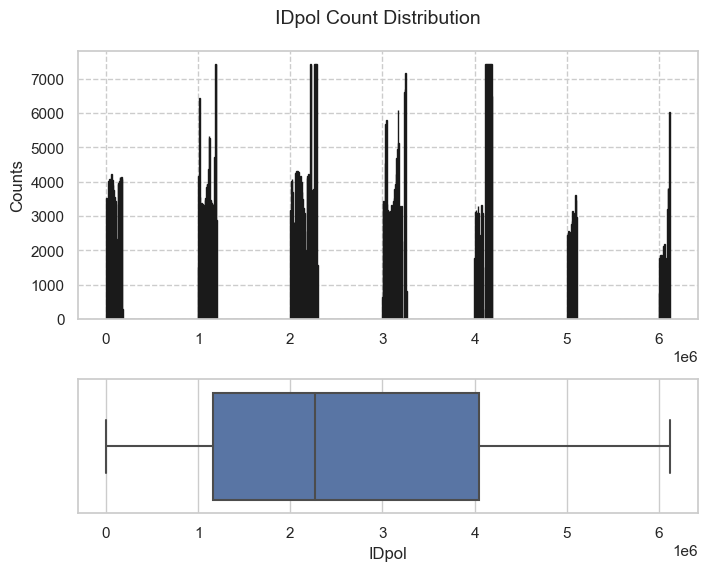

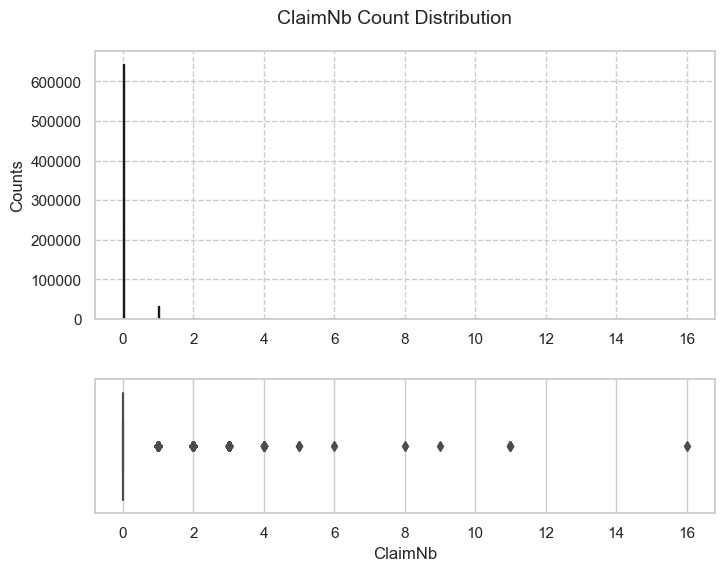

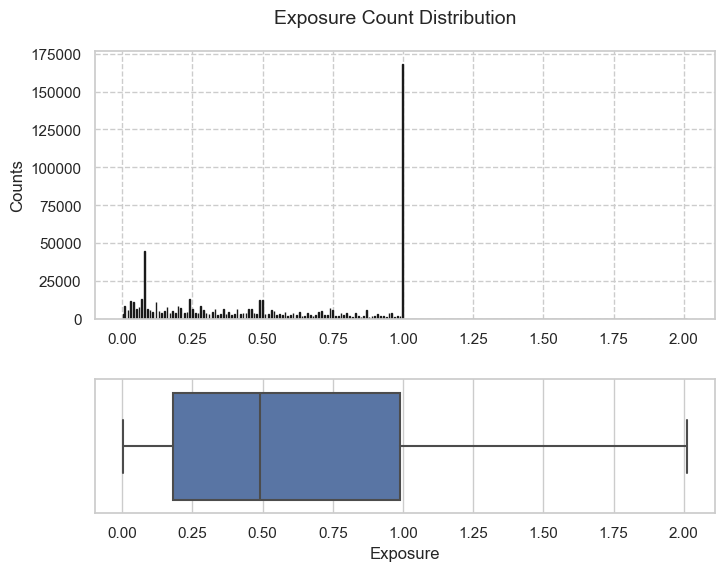

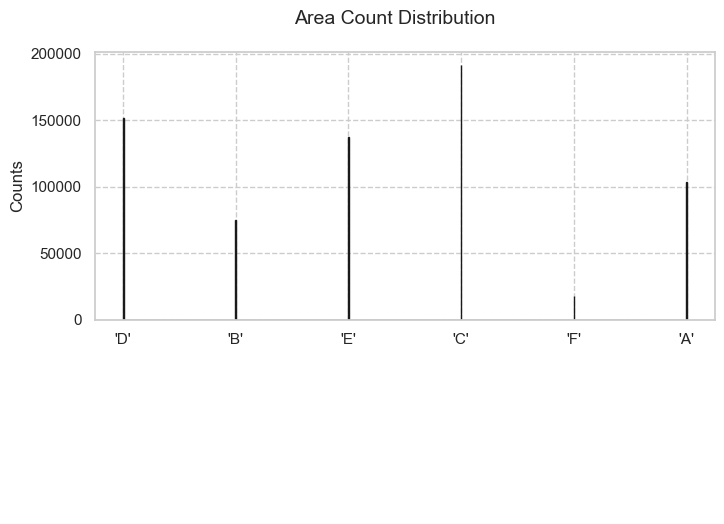

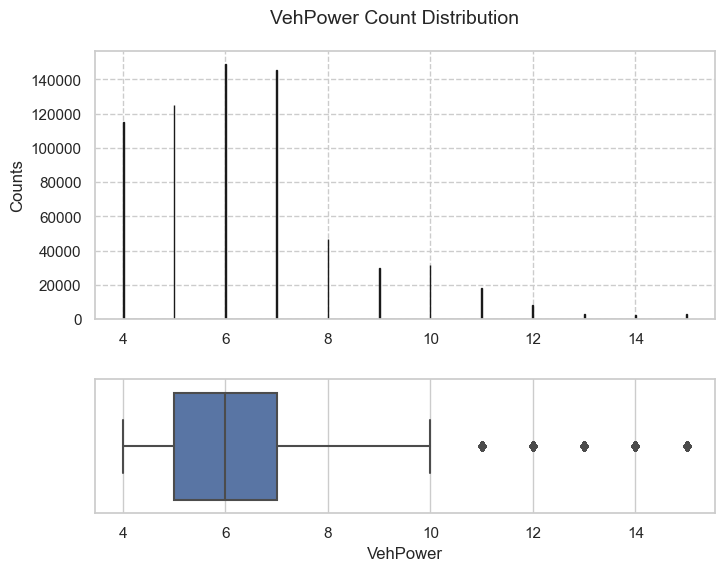

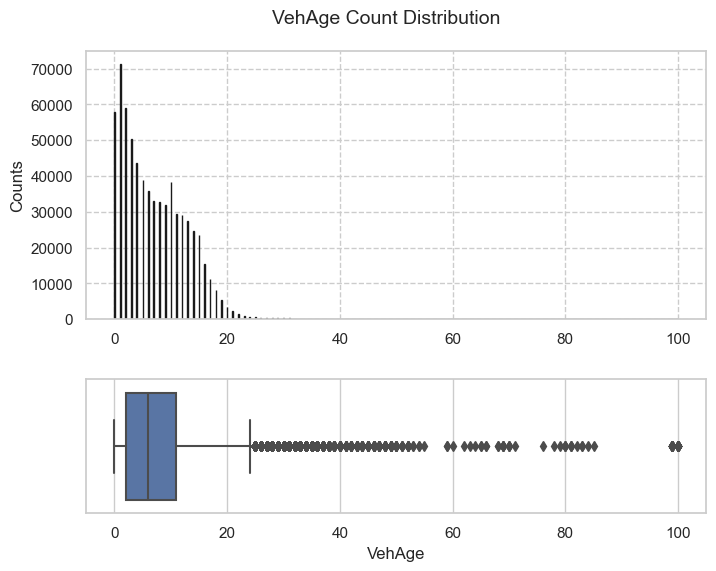

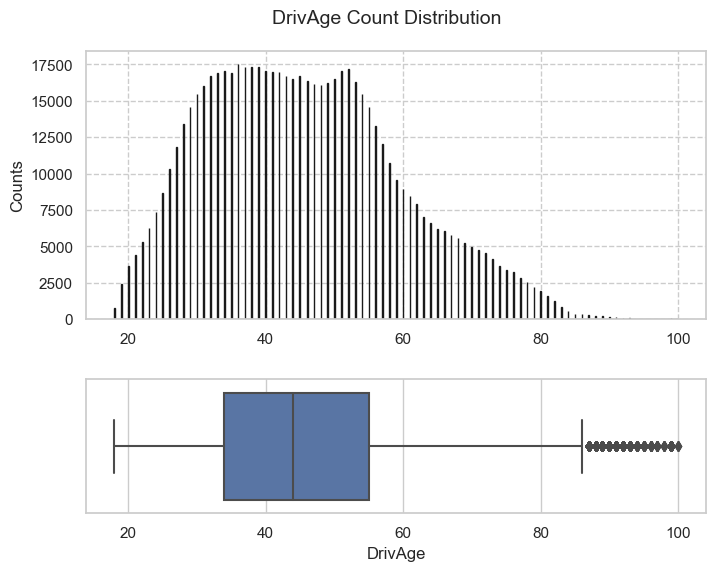

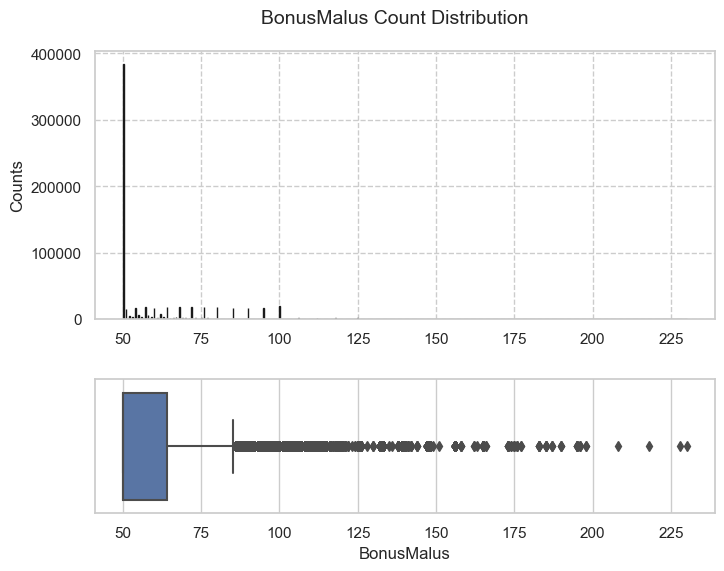

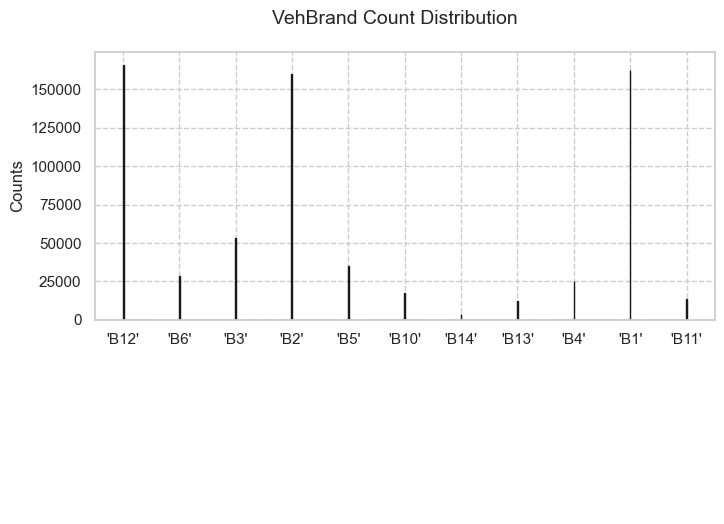

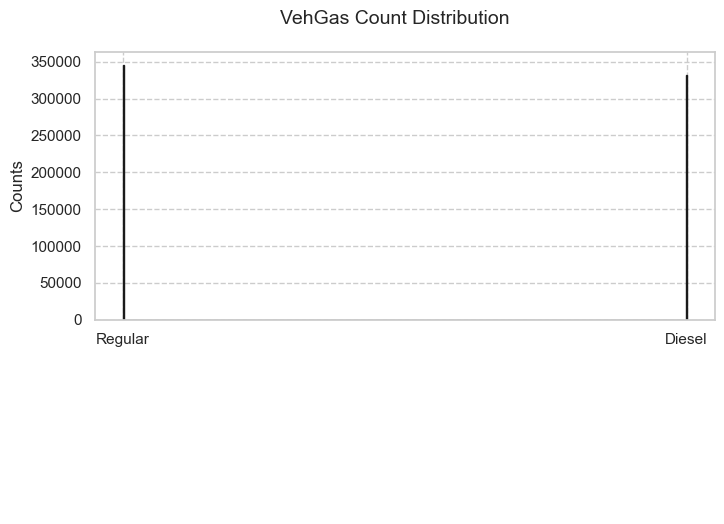

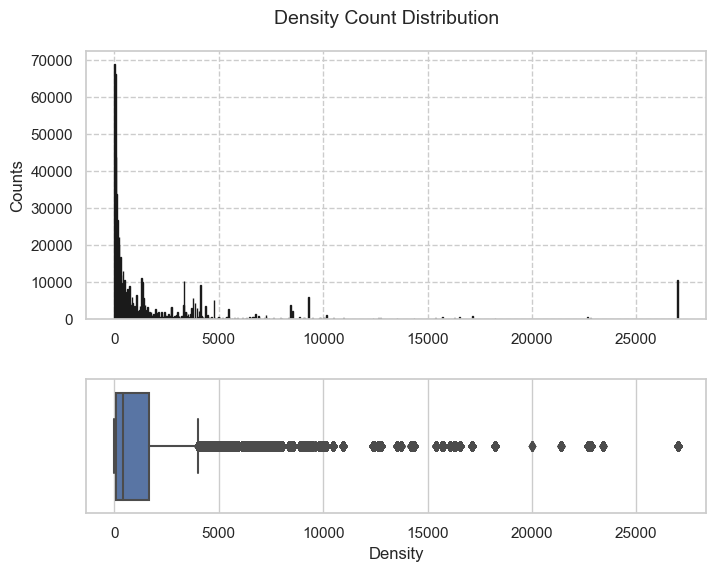

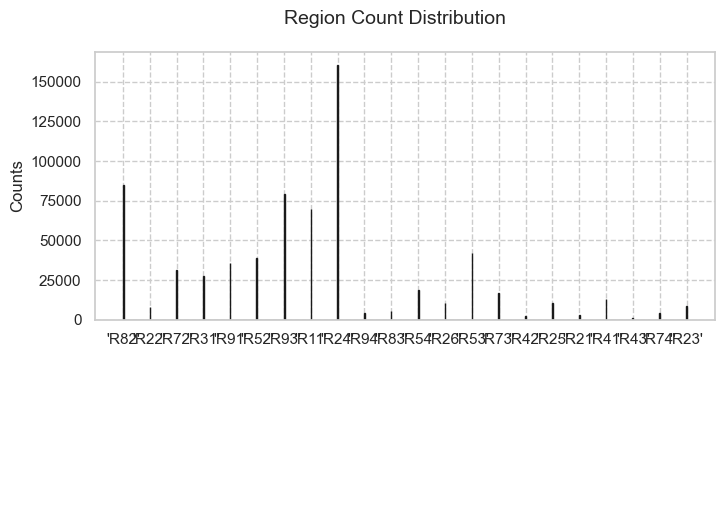

In [10]:
Dataset_Distributions(df_freq)

In [11]:
df_sev.sample(n=5)

,IDpol,ClaimAmount
9912,1040096.0,3238.28
14891,2150459.0,1172.00
5144,36271.0,564.06
17456,3152906.0,1204.00
11875,2110648.0,1172.00


In [12]:
df_sev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26639 entries, 0 to 26638
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IDpol        26639 non-null  float64
 1   ClaimAmount  26639 non-null  float64
dtypes: float64(2)
memory usage: 416.4 KB


In [13]:
df_sev.isna().sum().sum()

0

In [14]:
df_sev = df_sev.groupby('IDpol').sum('ClaimAmount').reset_index()

In [15]:
df_sev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24950 entries, 0 to 24949
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IDpol        24950 non-null  float64
 1   ClaimAmount  24950 non-null  float64
dtypes: float64(2)
memory usage: 390.0 KB


In [16]:
df_sev.describe()

,IDpol,ClaimAmount
count,2.495000e+04,2.495000e+04
mean,2.262558e+06,2.432783e+03
std,1.578285e+06,3.036192e+04
min,1.390000e+02,1.000000e+00
25%,1.082755e+06,7.498400e+02
50%,2.130128e+06,1.172000e+03
75%,3.178382e+06,1.346400e+03
max,6.113971e+06,4.075401e+06


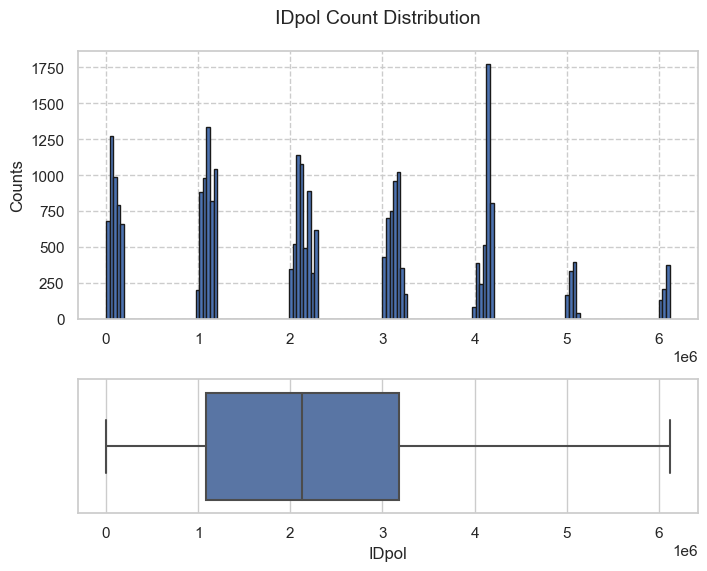

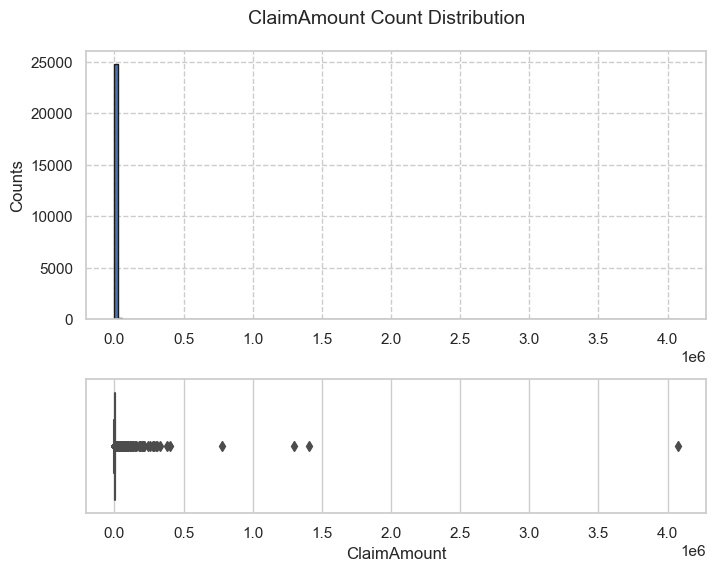

In [17]:
Dataset_Distributions(df_sev)

Most of the features show distributions that deviate from a Gaussian shape, with the presence of tails and outliers. The target variable is sparse, i.e. most values are zero.

<a id='eda'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Data Cleaning, Feature Engineering & EDA <span style="float:right;"> 2. </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

1. The data sets were merged on the basis of their common IDpol column. IDpol values for which no values were specified for the ClaimAmount were given the value zero.
2. The IDpol variable was removed as the aim is to create a model that can also be used for new customers.
3. The dependent variable was created as ClaimAmount / Exposure. In addition, a binary target variable was created: 0 if ClaimAmount is 0 and 1 if it is strictly positive.
4. The variable VehGasEnc is a categorical binary variable. It was encoded as a numeric binary variable.
5. The variables Area, VehBrand and Region are categorical variables. They were encoded numerically so that a higher number corresponds to a higher amount of damage.
6. The variables VehPower, DrivAge and VehAge show outliers. The outliers were cut out and set to the 0.75 quartile value.
7. The variables Density and BonusMalus also show outliers. These variables were binned.
8. The following cross-variables were created: DrivAgeCut * DensityBinned, VehAgeCut * DensityBinned, RegionEnc * DensityBinned, BonusMalusBinned * DensityBinned, DrivAgeCut * BonusMalusBinned.

In [18]:
# Merging the two datasets

df_0 = pd.merge(df_freq, df_sev, how='left', on='IDpol')

df = df_0.copy()

df.sample(n=5)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
209931,2020175.0,0.0,0.00274,'A',6.0,4.0,33.0,61.0,'B12',Diesel,16.0,'R82',NaN
298354,2206794.0,0.0,1.00000,'D',8.0,12.0,49.0,50.0,'B3',Regular,983.0,'R52',NaN
401981,3089171.0,0.0,0.59000,'C',7.0,10.0,32.0,50.0,'B2',Diesel,139.0,'R52',NaN
495415,4015883.0,0.0,0.53000,'D',6.0,3.0,69.0,50.0,'B12',Diesel,1175.0,'R54',NaN
169178,1157216.0,0.0,1.00000,'B',8.0,3.0,38.0,50.0,'B10',Diesel,61.0,'R24',NaN


In [19]:
# Checking for duplicates in the IDpol column

df['IDpol'].duplicated().sum()

0

In [20]:
# Dropping the IDpol column

df.drop('IDpol', axis=1, inplace=True)

In [21]:
# Checking for missing values

df.isna().sum()

ClaimNb             0
Exposure            0
Area                0
VehPower            0
VehAge              0
DrivAge             0
BonusMalus          0
VehBrand            0
VehGas              0
Density             0
Region              0
ClaimAmount    653069
dtype: int64

In [22]:
# Filling missing values with zeros

df.fillna(0, inplace=True)
df.isna().sum().sum()

0

In [23]:
# Creating target variables

df['ClaimAmountBin'] = df['ClaimAmount'].apply(lambda x: 1 if x > 0 else 0)

df['ExpClaimAmount'] = df['ClaimAmount']/df['Exposure']

print('Zero-claim istances as percentage of the total instances:', round(df['ClaimAmountBin'].value_counts()[0]/(len(df)) *100, 2))

Zero-claim istances as percentage of the total instances: 96.32


In [24]:
# Encoding VehGas variable as a binary numeric variable

df['VehGasEnc'] = df['VehGas'].apply(lambda x: 1 if x == 'Diesel' else 0)

In [25]:
# Encoding Area variable as a numeric variable. A higher number will correspond to a higher total ExpClaimAmount

area_total_claim = df.groupby(['Area'])[['ExpClaimAmount']].sum().sort_values('ExpClaimAmount').reset_index()

mapping = {value: index + 1 for index, value in enumerate(area_total_claim['Area'])}

df['AreaEnc'] = df['Area'].map(mapping)

In [26]:
# Encoding VehBrand variable as a numeric variable. A higher number will correspond to a higher total ExpClaimAmount

VehBrand_total_claim = df.groupby(['VehBrand'])[['ExpClaimAmount']].sum().sort_values('ExpClaimAmount').reset_index()

mapping = {value: index + 1 for index, value in enumerate(VehBrand_total_claim['VehBrand'])}

df['VehBrandEnc'] = df['VehBrand'].map(mapping)

In [27]:
# Encoding Region variable as a numeric variable. A higher number will correspond to a higher total ExpClaimAmount

Region_total_claim = df.groupby(['Region'])[['ExpClaimAmount']].sum().sort_values('ExpClaimAmount').reset_index()

mapping = {value: index + 1 for index, value in enumerate(Region_total_claim['Region'])}

df['RegionEnc'] = df['Region'].map(mapping)

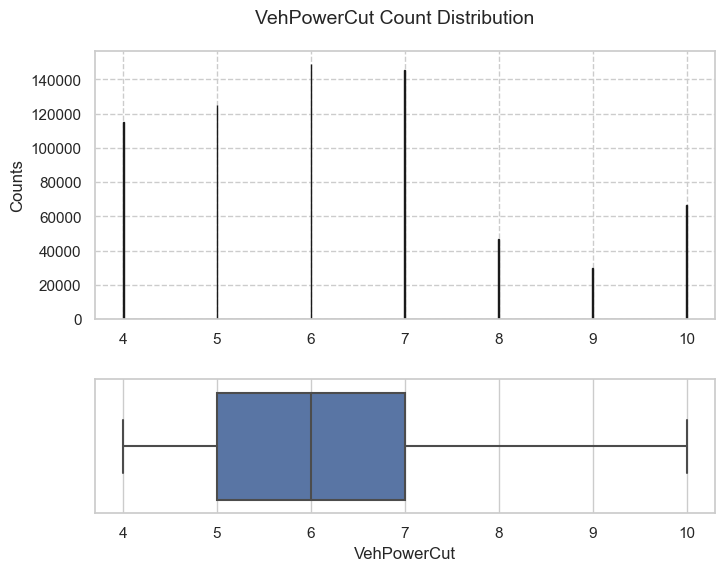

In [28]:
# Setting outliers to 0.75 quartile value

df['VehPowerCut'] = df['VehPower'].apply(lambda x: 10 if x > 10 else x)

Dataset_Distributions(df['VehPowerCut'].to_frame())

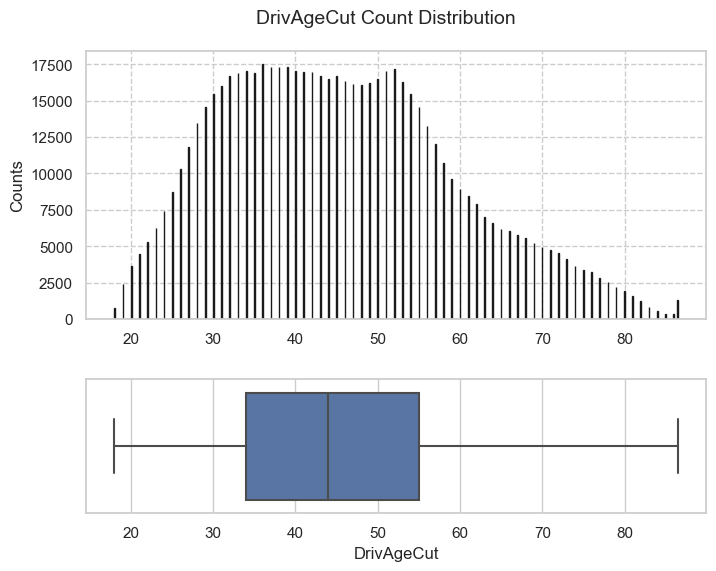

In [29]:
# Setting outliers to 0.75 quartile value

df['DrivAgeCut'] = df['DrivAge']

df.loc[df['DrivAgeCut'] > Outliers_Limits(df['DrivAgeCut'])[1], 'DrivAgeCut'] = Outliers_Limits(df['DrivAgeCut'])[1]

Dataset_Distributions(df['DrivAgeCut'].to_frame())

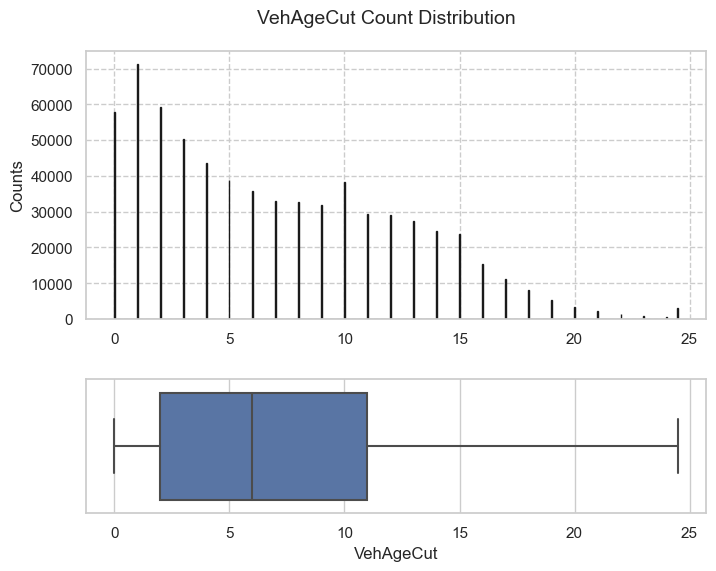

In [30]:
# Setting outliers to 0.75 quartile value

df['VehAgeCut'] = df['VehAge']

df.loc[df['VehAgeCut'] > Outliers_Limits(df['VehAgeCut'])[1], 'VehAgeCut'] = Outliers_Limits(df['VehAgeCut'])[1]

Dataset_Distributions(df['VehAgeCut'].to_frame())

In [31]:
Outliers_Limits(df['Density'])[1]

4007.0

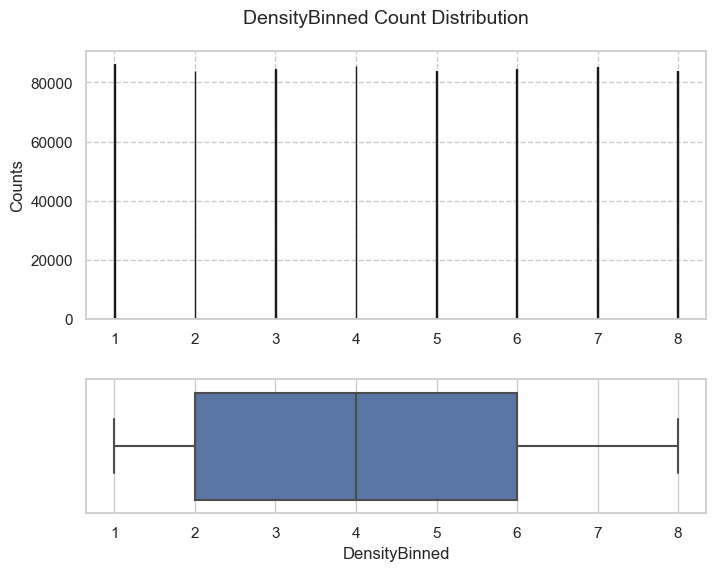

In [32]:
# Binning Density variable based on quartile ranges

df['DensityBinned'] = pd.qcut(df['Density'], q=8, labels=False) +1

Density_quantiles = df.groupby('DensityBinned')['Density'].agg(['min', 'max'])
Density_quantiles.columns = ['Density_Min', 'Density_Max']

Dataset_Distributions(df['DensityBinned'].to_frame())

In [33]:
Density_quantiles

,Density_Min,Density_Max
DensityBinned,,
1,1.0,42.0
2,43.0,92.0
3,93.0,188.0
4,189.0,393.0
5,394.0,817.0
6,818.0,1658.0
7,1662.0,3859.0
8,3862.0,27000.0


In [34]:
Outliers_Limits(df['BonusMalus'])[1]

85.0

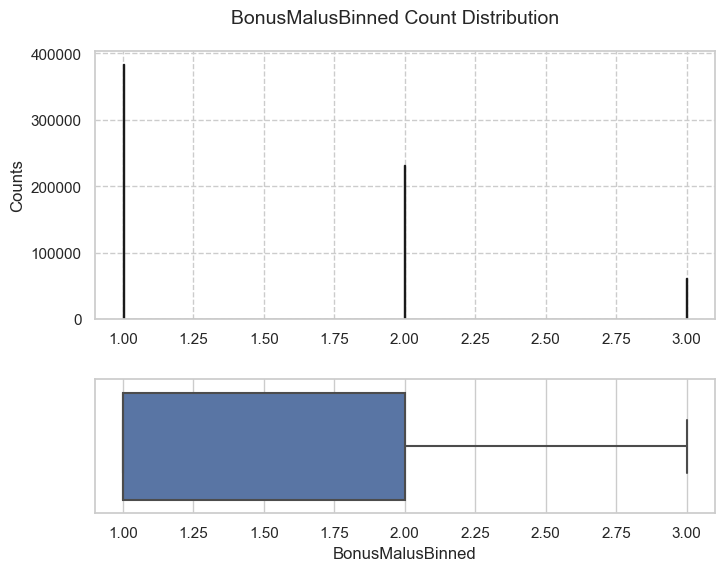

In [35]:
# Binning BonusMalus variable based on 0.75 quartile value

bin_edges = [0, 50, 85, 300]
bin_labels = [1, 2, 3]

df['BonusMalusBinned'] = pd.cut(df['BonusMalus'], bins=bin_edges, labels=bin_labels)
df['BonusMalusBinned'] = df['BonusMalusBinned'].astype(int)

Dataset_Distributions(df['BonusMalusBinned'].to_frame())

In [36]:
df.sample(n=5)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmountBin,ExpClaimAmount,VehGasEnc,AreaEnc,VehBrandEnc,RegionEnc,VehPowerCut,DrivAgeCut,VehAgeCut,DensityBinned,BonusMalusBinned
530168,0.0,1.00,'D',7.0,13.0,42.0,50.0,'B1',Diesel,522.0,'R52',0.0,0,0.0,1,5,10,18,7.0,42.0,13.0,5,1
44951,0.0,0.02,'E',4.0,0.0,51.0,63.0,'B1',Regular,2103.0,'R25',0.0,0,0.0,0,6,10,10,4.0,51.0,0.0,7,2
409800,0.0,1.00,'A',9.0,15.0,44.0,50.0,'B1',Regular,39.0,'R72',0.0,0,0.0,0,2,10,14,9.0,44.0,15.0,1,1
323915,0.0,0.08,'D',6.0,15.0,30.0,85.0,'B1',Regular,1210.0,'R82',0.0,0,0.0,0,5,10,21,6.0,30.0,15.0,6,2
175243,0.0,0.25,'B',6.0,2.0,23.0,80.0,'B3',Diesel,56.0,'R82',0.0,0,0.0,1,3,8,21,6.0,23.0,2.0,2,2


In [37]:
# Selecting features

selected_features_1 = ['ClaimAmountBin', 'VehGasEnc', 'AreaEnc', 'VehBrandEnc', 'RegionEnc', 'VehPowerCut', 
                     'DrivAgeCut', 'VehAgeCut', 'DensityBinned', 'BonusMalusBinned']

predictors_1 = df[selected_features_1].copy().drop('ClaimAmountBin', axis=1)

It is common practice not to select variables with a Variance Inflation Factor (VIF) of more than 5-10 as they could indicate the presence of multicollinearity.

In [38]:
# Creating cross features

df['DrivAge_cdot_Density'] = df['DrivAgeCut'] *df['DensityBinned']
df['VehAge_cdot_Density'] = df['VehAgeCut'] *df['DensityBinned']
df['Region_cdot_Density'] = df['RegionEnc'] *df['DensityBinned']
df['BM_cdot_Density'] = df['BonusMalusBinned'] *df['DensityBinned'] 
df['DrivAge_cdot_BM'] = df['DrivAgeCut'] *df['BonusMalusBinned'] 

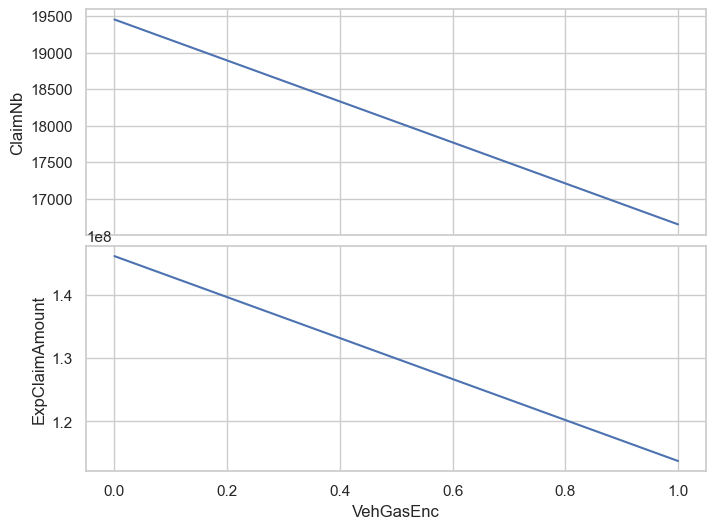

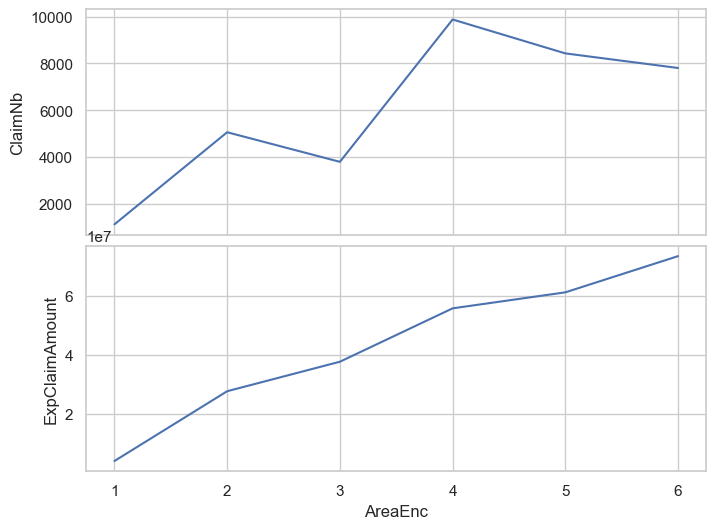

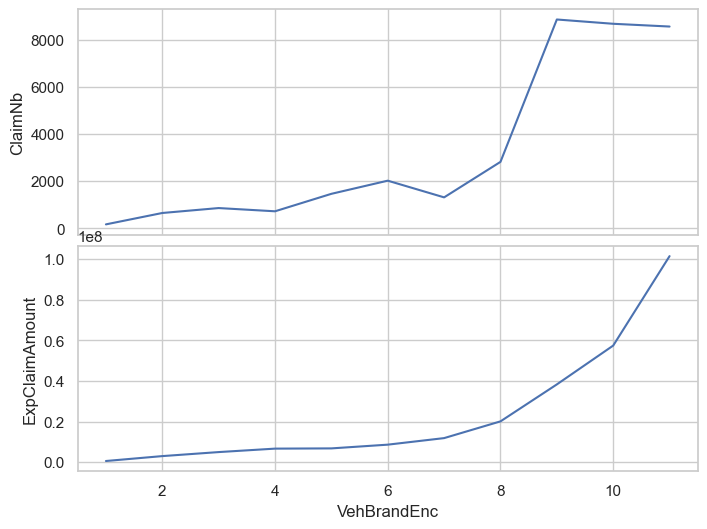

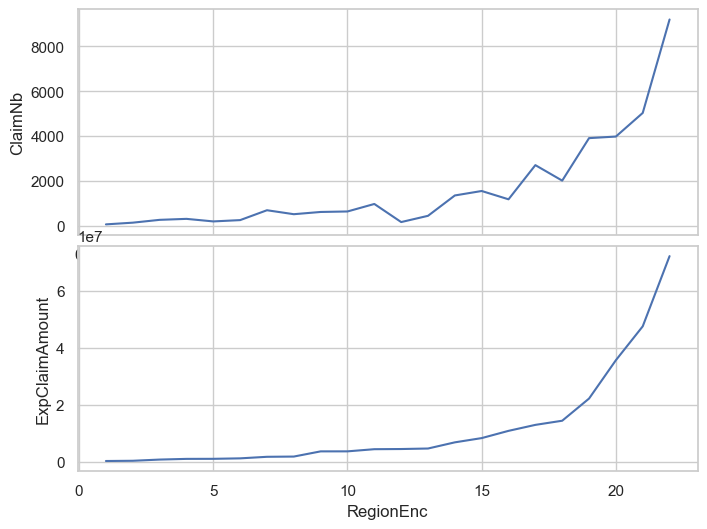

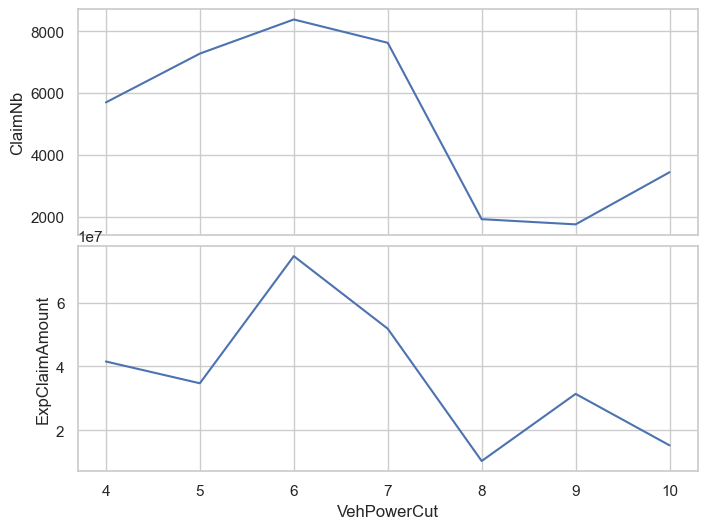

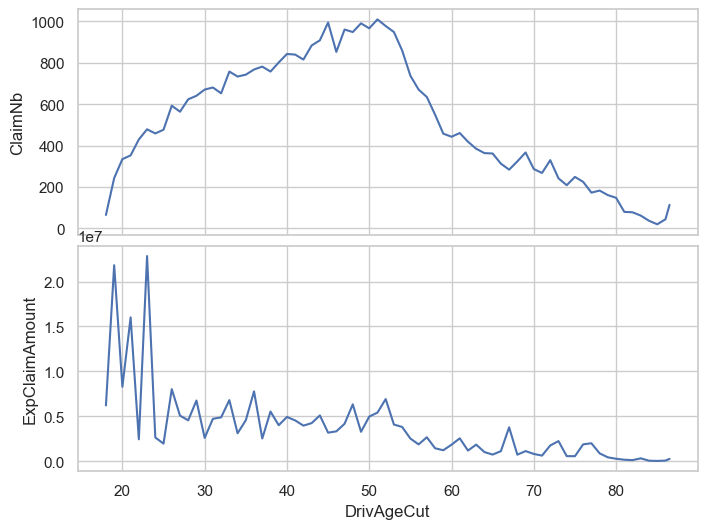

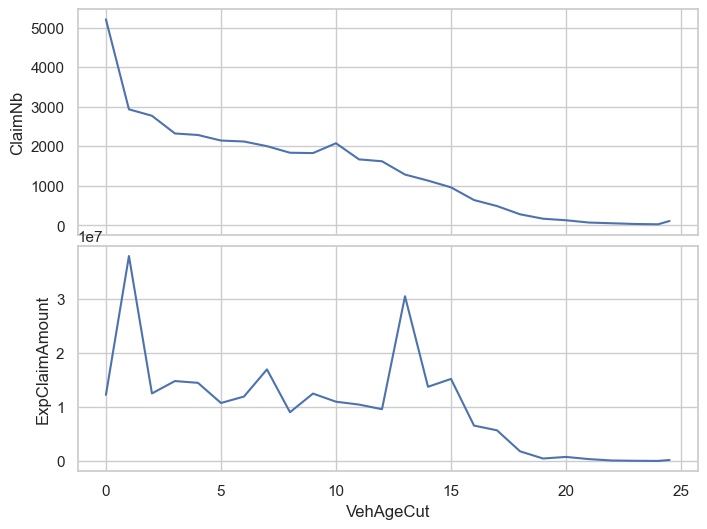

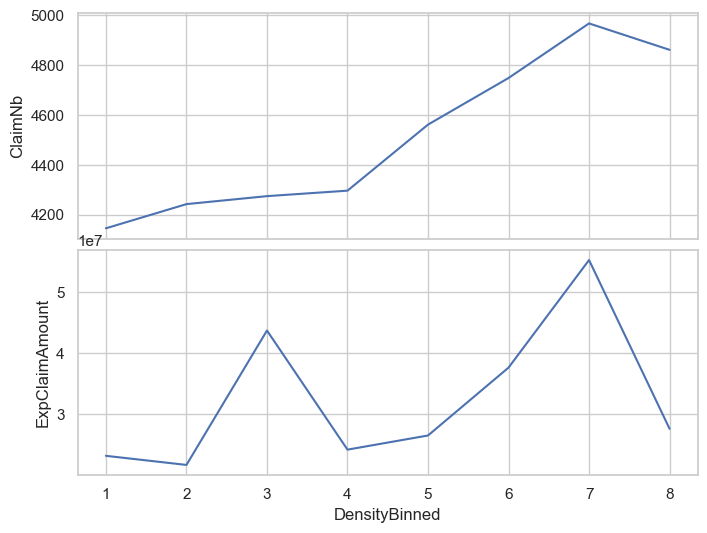

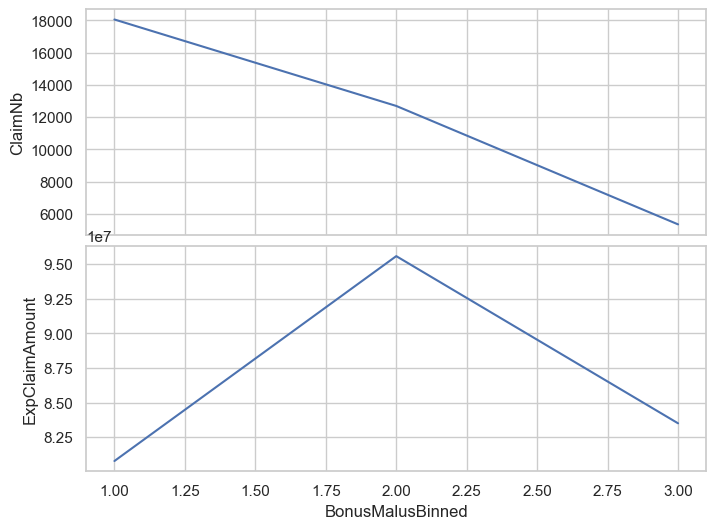

In [56]:
# Seeking correlations between predictors and target variables

target_1 = 'ClaimNb'
target_2 = 'ExpClaimAmount'

for predictor in predictors_1:
    Target_Predictor(target_1, target_2, predictor)

#### EDA:

1. In some areas and regions, the number of claims and the total claimed amount is higher than in others.
2. The smaller the bonus penalty, the higher the number of claims. This does not apply to the total claimed amount.
3. The higher the population density, the higher the number of claims. This does not apply to the total claimed amount.
4. The number of claims increases with driver age, up to the age of 50, after which it decreases.
5. The total claimed amount is highest among 18- to 25-year-olds. It remains somewhat constant for older people.
6. The number of claims decreases the older the vehicles are. The total claimed amount also decreases with vehicle age, with peaks at 1 year old vehicles and between 12-15 years old vehicles.
7. Certain vehicle brands and vehicle power show a higher number of claims and total claimed amount.
8. Statistical tests should be conducted to determine if the above statements are statistically significant.

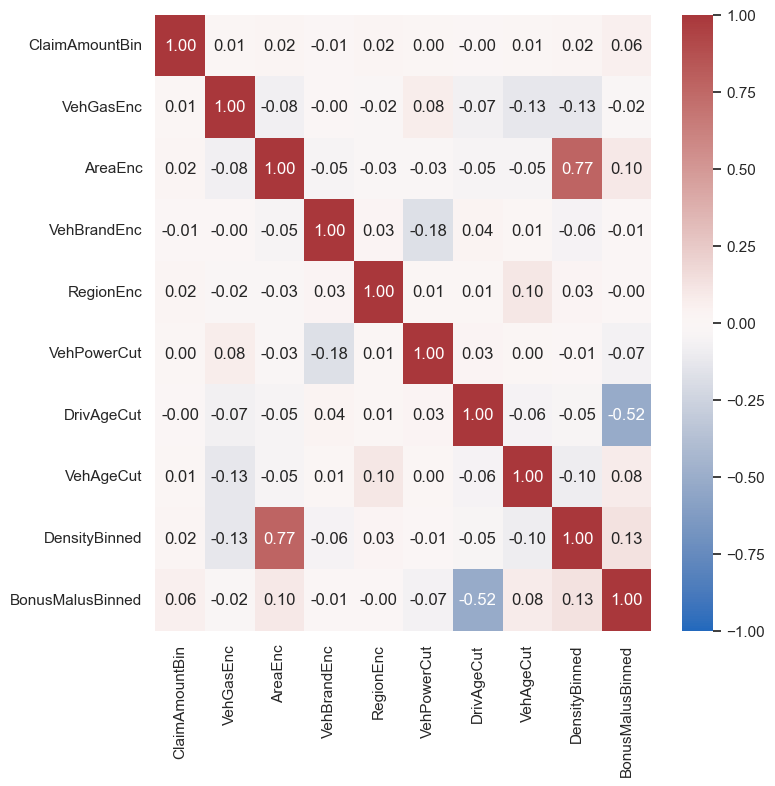

In [40]:
# Seeking for correlations between predictors and target variables and multi-collinearity

fig, ax = plt.subplots(figsize = (8,8))

heatmap = sns.heatmap(df[selected_features_1].corr(), vmin=-1, vmax=1, fmt='.2f', 
                      annot=True, cmap=sns.color_palette("vlag", as_cmap=True))

plt.show()

<a id='model'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Modeling <span style="float:right;"> 3. </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

My strategy for predicting the target variable consists of an initial logistic XGBoost classification model and a subsequent XGBoost regression model. The classification model predicts whether the claimed amount will be zero (0) or strictly higher (1). The regression model aims to improve the strictly positive claimed amounts.

Different groups of predictors are tested based on their VIF values and correlations.

The ClaimNb variable was not used for the classification model as this would have led to data leakage.

The classification model is a logistic XGBoost model that is trained using cost-sensitive learning to deal with the imbalance of classes.

Different values of hyperparameters (learning rate, number of estimators, regression parameters, max depth) were tested.

# <div style='color:b; background-color:w; text-align:left; font-size:75%; font-family:Arial; margin-top: 75px;'> Step 1: Classification Model <span style="float:right;"> 3.1 </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

In [41]:
X = predictors_1
y = df['ClaimAmountBin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [42]:
vif = pd.DataFrame()

vif['Variable'] = X_train.columns

vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif

,Variable,VIF
0,VehGasEnc,2.017336
1,AreaEnc,21.969612
2,VehBrandEnc,13.013606
3,RegionEnc,12.605165
4,VehPowerCut,11.242637
5,DrivAgeCut,11.251512
6,VehAgeCut,2.742332
7,DensityBinned,12.374454
8,BonusMalusBinned,6.867489


Precision: 0.9328
Recall: 0.7433
Accuracy: 0.7433
AUC Score: 0.5503


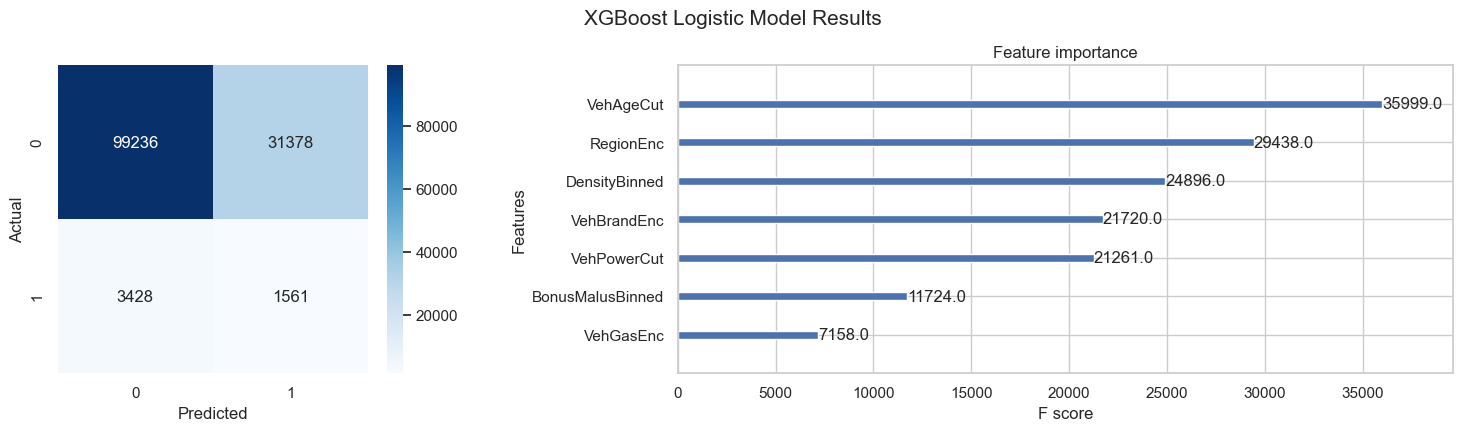

In [43]:
X = df[vif['Variable'].values].drop('AreaEnc', axis=1).drop('DrivAgeCut', axis=1)
y = df['ClaimAmountBin']

XGBoost_Logistic(X, y, learning_rate=0.75, n_estimators=2500, reg_alpha=0.25, reg_lambda=0.25)

In [44]:
selected_features_2 = ['ClaimAmountBin', 'VehGasEnc', 'AreaEnc', 'VehBrandEnc', 'RegionEnc', 'VehPowerCut', 
                     'DrivAgeCut', 'VehAgeCut', 'DensityBinned', 'BonusMalusBinned', 
                     'DrivAge_cdot_Density', 'VehAge_cdot_Density', 'Region_cdot_Density',
                     'BM_cdot_Density', 'DrivAge_cdot_BM']

predictors_2 = df[selected_features_2].copy().drop('ClaimAmountBin', axis=1)

X = predictors_2
y = df['ClaimAmountBin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

vif_2 = pd.DataFrame()

vif_2['Variable'] = X_train.columns

vif_2['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif_2

,Variable,VIF
0,VehGasEnc,2.048412
1,AreaEnc,24.572815
2,VehBrandEnc,15.570288
3,RegionEnc,50.515536
4,VehPowerCut,13.130265
5,DrivAgeCut,60.006794
6,VehAgeCut,12.554363
7,DensityBinned,134.963213
8,BonusMalusBinned,55.166917
9,DrivAge_cdot_Density,53.744949


Precision: 0.9337
Recall: 0.599
Accuracy: 0.599
AUC Score: 0.5427


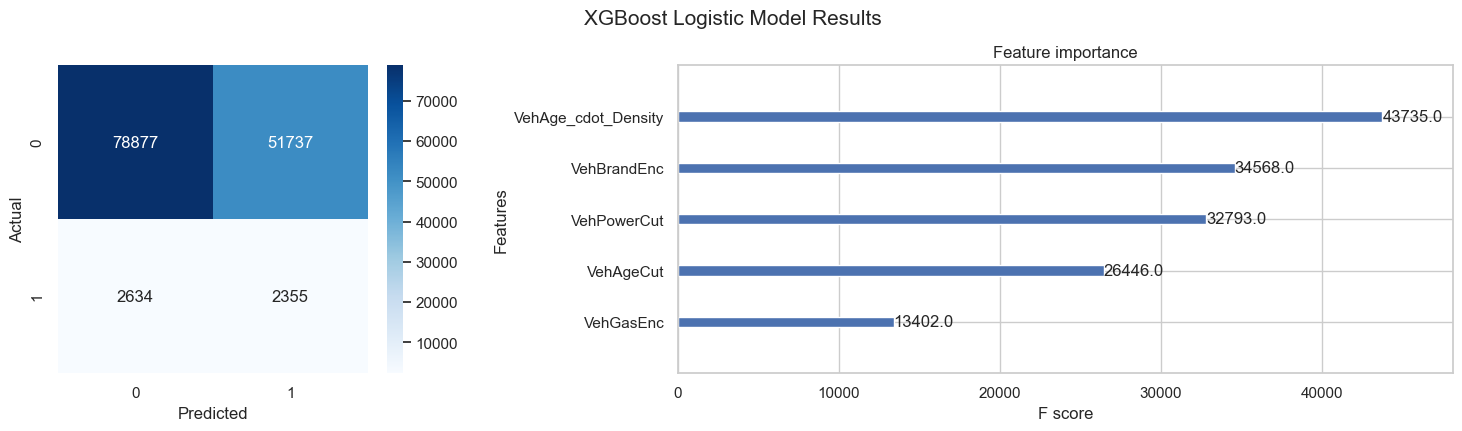

In [45]:
X = df[['VehGasEnc', 'VehBrandEnc', 'VehPowerCut', 'VehAgeCut', 'VehAge_cdot_Density']]
y = df['ClaimAmountBin']

XGBoost_Logistic(X, y, learning_rate=0.75, n_estimators=2500, reg_alpha=0.25, reg_lambda=0.25)

In [46]:
selected_features_3 = ['ClaimAmountBin', 'DrivAge_cdot_Density', 'VehAge_cdot_Density', 'Region_cdot_Density',
                     'BM_cdot_Density', 'DrivAge_cdot_BM']

predictors_3 = df[selected_features_3].copy().drop('ClaimAmountBin', axis=1)

X = predictors_3
y = df['ClaimAmountBin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

vif_3 = pd.DataFrame()

vif_3['Variable'] = X_train.columns

vif_3['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif_3

,Variable,VIF
0,DrivAge_cdot_Density,9.103643
1,VehAge_cdot_Density,2.481927
2,Region_cdot_Density,12.503716
3,BM_cdot_Density,6.956537
4,DrivAge_cdot_BM,4.818537


Precision: 0.931
Recall: 0.7759
Accuracy: 0.7759
AUC Score: 0.5356


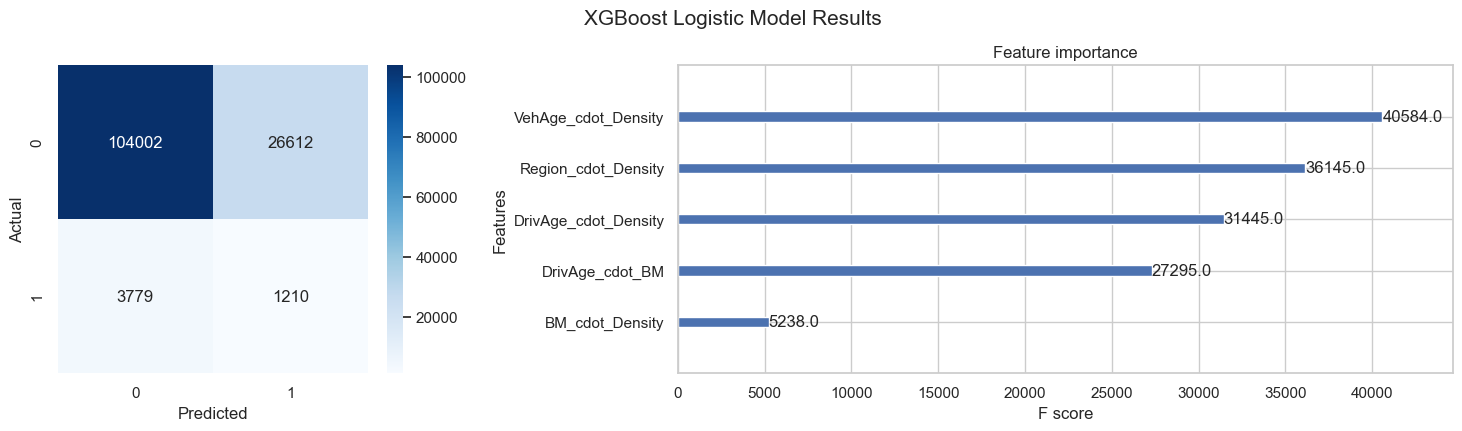

In [47]:
X = df[vif_3['Variable'].values]
y = df['ClaimAmountBin']

XGBoost_Logistic(X, y, learning_rate=0.75, n_estimators=2500, reg_alpha=0.25, reg_lambda=0.25)

The best classification model achieves the following metric values when tested to the test dataset: 0.93 Precision, 0.78 Accuracy, 0.78 Recall, ROC-AUC Score: 0.534. The model does ok at classifying zero values, but has problems with positive values.

# <div style='color:b; background-color:w; text-align:left; font-size:75%; font-family:Arial; margin-top: 75px;'> Step 2: Regression Model <span style="float:right;"> 3.2 </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

In [48]:
df_PositiveClaims = df[df['ExpClaimAmount'] > 0].copy()

In [49]:
X = df_PositiveClaims[selected_features_1].copy()
X['ClaimNb'] = df_PositiveClaims['ClaimNb']
X.drop('ClaimAmountBin', axis=1, inplace=True)
y = df_PositiveClaims['ExpClaimAmount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vif = pd.DataFrame()

vif['Variable'] = X_train.columns

vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif

,Variable,VIF
0,VehGasEnc,2.069288
1,AreaEnc,22.614083
2,VehBrandEnc,11.963462
3,RegionEnc,14.555152
4,VehPowerCut,11.768019
5,DrivAgeCut,10.849441
6,VehAgeCut,3.241136
7,DensityBinned,13.076022
8,BonusMalusBinned,7.500930
9,ClaimNb,12.294673


In [50]:
X.drop('AreaEnc', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

R2 Score on Test Set:  -1.7783


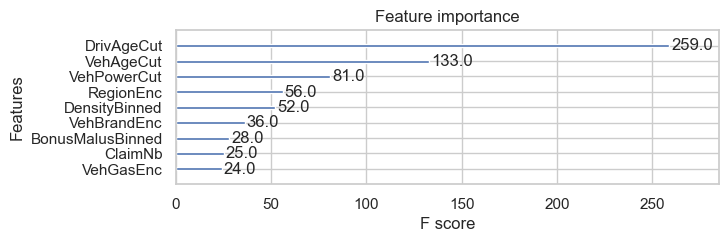

In [51]:
xgb_model = xgb.XGBRegressor(learning_rate=0.75, n_estimators=100, max_depth=3, reg_alpha=0.25, reg_lambda=0.25)
xgb_model.fit(X_train,y_train)

y_pred = xgb_model.predict(X_test)

r2 = round(r2_score(y_test, y_pred), 4)
print("R2 Score on Test Set: ", r2)

fig, ax = plt.subplots(figsize = (7,2))
xgb.plot_importance(xgb_model, importance_type='weight', ax=ax)
plt.show()

In [52]:
X = df_PositiveClaims[selected_features_2].copy()
X['ClaimNb'] = df_PositiveClaims['ClaimNb']
X.drop('ClaimAmountBin', axis=1, inplace=True)
y = df_PositiveClaims['ExpClaimAmount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vif_2 = pd.DataFrame()

vif_2['Variable'] = X_train.columns

vif_2['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif_2

,Variable,VIF
0,VehGasEnc,2.101198
1,AreaEnc,24.706109
2,VehBrandEnc,13.910855
3,RegionEnc,62.727208
4,VehPowerCut,13.668669
5,DrivAgeCut,67.464859
6,VehAgeCut,16.202326
7,DensityBinned,140.305269
8,BonusMalusBinned,60.940726
9,DrivAge_cdot_Density,53.833890


R2 Score on Test Set:  -0.0655


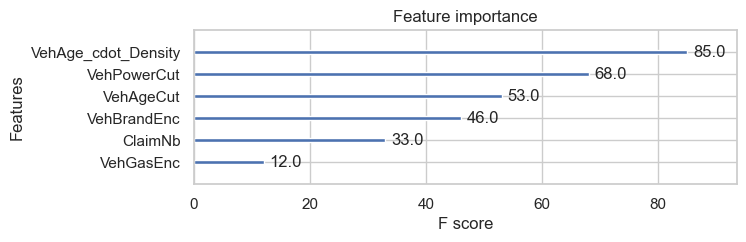

In [53]:
X = df_PositiveClaims[['VehGasEnc', 'VehBrandEnc', 'VehPowerCut', 'VehAgeCut', 'VehAge_cdot_Density', 'ClaimNb']]
y = df_PositiveClaims['ExpClaimAmount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(learning_rate=0.75, n_estimators=100, max_depth=2, reg_alpha=0.25, reg_lambda=0.25)
xgb_model.fit(X_train,y_train)

y_pred = xgb_model.predict(X_test)

r2 = round(r2_score(y_test, y_pred), 4)
print("R2 Score on Test Set: ", r2)

fig, ax = plt.subplots(figsize = (7,2))
xgb.plot_importance(xgb_model, importance_type='weight', ax=ax)
plt.show()

In [54]:
X = df_PositiveClaims[selected_features_3].copy()
X['ClaimNb'] = df_PositiveClaims['ClaimNb']
X.drop('ClaimAmountBin', axis=1, inplace=True)
y = df_PositiveClaims['ExpClaimAmount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vif_3 = pd.DataFrame()

vif_3['Variable'] = X_train.columns

vif_3['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif_3

,Variable,VIF
0,DrivAge_cdot_Density,9.743928
1,VehAge_cdot_Density,3.057501
2,Region_cdot_Density,16.096857
3,BM_cdot_Density,8.482616
4,DrivAge_cdot_BM,7.961065
5,ClaimNb,6.305996


R2 Score on Test Set:  -0.1524


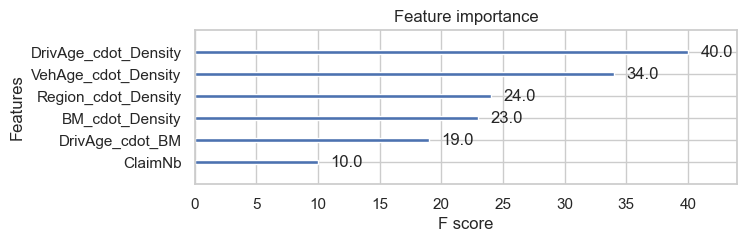

In [55]:
X = df_PositiveClaims[vif_3['Variable'].values].copy()
X['ClaimNb'] = df_PositiveClaims['ClaimNb']
y = df_PositiveClaims['ExpClaimAmount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(learning_rate=0.75, n_estimators=50, max_depth=2, reg_alpha=0.5, reg_lambda=0.1)
xgb_model.fit(X_train,y_train)

y_pred = xgb_model.predict(X_test)

r2 = round(r2_score(y_test, y_pred), 4)
print("R2 Score on Test Set: ", r2)

fig, ax = plt.subplots(figsize = (7,2))
xgb.plot_importance(xgb_model, importance_type='weight', ax=ax)
plt.show()

The best XGBoost regression model trained only on data with a strictly positive target variable has a negative R2 value when tested to the test dataset. The model therefore perform worse than a horizontal line fitting the data (a model that simply predicts the mean of the target variable). A different approach is needed.

<a id='end'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Results & Next Steps  <span style="float:right;"> 4. </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

#### Key Insights:

1. In some areas and regions, the number of claims and the total claimed amount is higher than in others.
2. The smaller the bonus penalty, the higher the number of claims. This does not apply to the total claimed amount.
3. The higher the population density, the higher the number of claims. This does not apply to the total claimed amount.
4. The number of claims increases with driver age, up to the age of 50, after which it decreases.
5. The total claimed amount is highest among 18- to 25-year-olds. It remains somewhat constant for older people.
6. The number of claims decreases the older the vehicles are. The total claimed amount also decreases with vehicle age, with peaks at 1 year old vehicles and between 12-15 years old vehicles.
7. Certain vehicle brands and vehicle power show a higher number of claims and total claimed amount.
8. Statistical tests should be conducted to determine if the above statements are statistically significant.
9. The best logistic XGBoost model has the following metric values: 0.93 Precision, 0.78 Accuracy, 0.78 Recall, ROC-AUC Score: 0.534. the model does well at classifying zero values, but has problems with positive values.
10. The best XGBoost regression model performs worse than a mean model.


#### Next Steps:

1. Apply oversampling techniques to reduce the class imbalance (null, non-null claim amount).
2. Apply hyperparameter tuning to each model via GridSearchCV with the goal of improving the models' metrics.
3. Test the performance of a Neural Network model.
4. Increase the historical time span of the dataset.
5. Retrieve additional predictors.